In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.sort()
sys.path.reverse()
try:
    sys.path.remove('../MEVA')
except:
    pass
sys.path.append('../MEVA')
sys.path

['/opt/rh/devtoolset-7/root/usr/lib64/python2.7/site-packages',
 '/opt/rh/devtoolset-7/root/usr/lib/python2.7/site-packages',
 '/home/nsx175/miniconda3/envs/apec/lib/python36.zip',
 '/home/nsx175/miniconda3/envs/apec/lib/python3.6/site-packages/IPython/extensions',
 '/home/nsx175/miniconda3/envs/apec/lib/python3.6/site-packages',
 '/home/nsx175/miniconda3/envs/apec/lib/python3.6/lib-dynload',
 '/home/nsx175/miniconda3/envs/apec/lib/python3.6',
 '/home/nsx175/.ipython',
 '',
 '../MEVA']

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import mmcv
from PIL import Image
from tqdm.auto import tqdm, trange
import os
import glob
from IPython import display

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.transforms.functional.to_pil_image(inp)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
vid_file = '/home/nsx175/ucph-erda-home/videos/IMG_2139.MOV'
vid = mmcv.video.VideoReader(vid_file)

In [7]:
#from data import VideoFrameFolder
# data_transforms = {
#     'train': transforms.Compose([
#         #transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


# val_dataset = VideoFrameFolder('/home/tormod/ucph-erda-home/frames/',
#                               transform=data_transforms['val'])
# val_dataloader = torch.utils.data.DataLoader(val_dataset,
#                                             batch_size=30,
#                                             shuffle=False,
#                                             num_workers=8)

## MMTracking

In [8]:
import mmtrack
import bbox
from mmtrack.apis import init_model

In [9]:
track_model = init_model('../mmtracking/configs/mot/tracktor/tracktor_faster-rcnn_r50_fpn_4e_mot17-private.py')
#track_model = init_model('../mmtracking/configs/vid/selsa/selsa_faster_rcnn_r50_dc5_1x_imagenetvid.py')
#track_model = init_model('../mmtracking/configs/vid/dff/dff_faster_rcnn_r50_dc5_1x_imagenetvid.py')

2021-03-31 12:24:30,157 - mmtrack - INFO - load detector from: https://download.openmmlab.com/mmtracking/mot/faster_rcnn/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth
2021-03-31 12:24:30,333 - mmtrack - INFO - load reid from: https://download.openmmlab.com/mmtracking/mot/reid/tracktor_reid_r50_iter25245-a452f51f.pth


In [31]:
bboxes = bbox.detect_mot(track_model, vid, only_first=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
bboxes.shape

(100, 4)

In [12]:
#mmcv.frames2video('tmp_frames', 'zoom_test.mp4', fps=vid.fps)

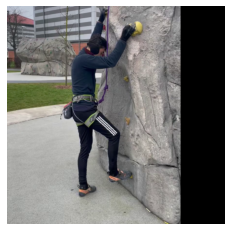

In [13]:
imshow(bbox.bbox_crop(vid[0], bboxes[0]))

# MMPose HMR

In [14]:
from mmpose.apis import init_pose_model
from mesh import inference_mesh_model, get_vertices
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
from meva.utils.renderer import Renderer
os.environ['PYOPENGL_PLATFORM'] = 'egl'

../MEVA/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [16]:
hmr_model = init_pose_model('/home/nsx175/mmpose/configs/mesh/hmr/hmr_res50_224x224.py',
                            'models/hmr_mesh_224x224-c21e8229_20201015.pth')

In [74]:
def predict_mesh(hmr_model, img, frame_bbox):
    hmr_model.eval()
    bbox_xywh = bbox.xyxy2xywh(frame_bbox[np.newaxis])[0]
    person_results = [dict(bbox=bbox_xywh)]
    _, res = inference_mesh_model(hmr_model, 
                                  img, 
                                  person_results,
                                  format='xywh')
    verts = get_vertices(hmr_model, res)

    orig_height, orig_width, _ = img.shape
    print(bbox_xywh)
    center, scale = bbox.box2cs(bbox_xywh, (orig_height, orig_width))
    
    bbox_csh = np.concatenate((center, scale))[np.newaxis]
    
    bbox_csh[:,2] = bbox_xywh[3]
    
    orig_cam = convert_crop_cam_to_orig_img(res['cam'], bbox_csh, orig_width, orig_height)
    res['verts'] = verts
    res['orig_cam'] = orig_cam
    
    return res

def render_mesh(img, verts, orig_cam):
    orig_height, orig_width, _ = img.shape
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    mesh_img = renderer.render(img, verts, orig_cam)
    return mesh_img


[249.6385498  309.82128906 343.4630127  690.82312012]


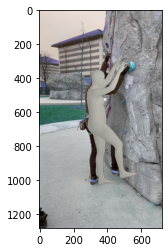

[267.0383606  353.3972168  264.41348267 664.22521973]


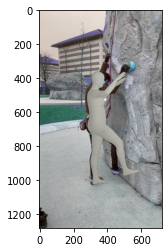

[257.92550659 296.45974731 319.81454468 720.14846802]


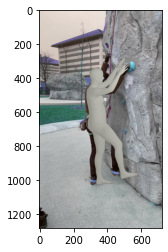

[251.95500183 314.40609741 333.58277893 692.33584595]


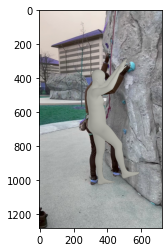

[261.76226807 278.49597168 319.25476074 744.63061523]


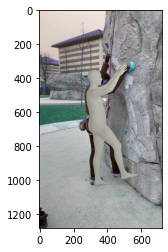

[259.10681152 354.69363403 255.33734131 659.46017456]


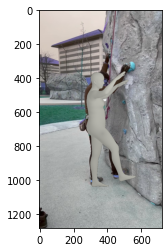

[254.71783447 357.01437378 250.24710083 664.65908813]


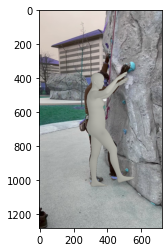

[254.00556946 360.86740112 248.19767761 664.68936157]


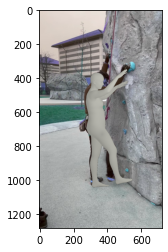

[259.67428589 247.32432556 323.53695679 777.20259094]


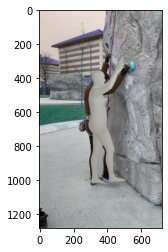

[259.93389893 252.25013733 322.46588135 776.5486908 ]


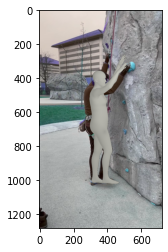

[262.44256592 255.80375671 318.01867676 776.4535675 ]


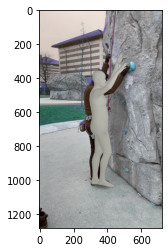

[259.28945923 251.15545654 337.1711731  777.28363037]


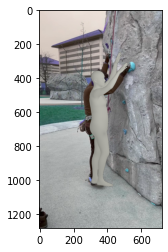

[258.48114014 263.94943237 325.61248779 778.81338501]


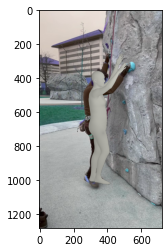

[231.10310364 340.96929932 191.44300842 676.51782227]


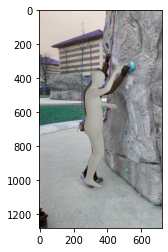

[222.83082581 345.19644165 208.448349   682.13583374]


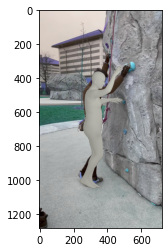

[216.8908844  346.98510742 212.14723206 679.7668457 ]


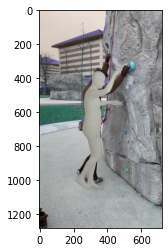

[216.2774353  352.50506592 213.2114563  670.15905762]


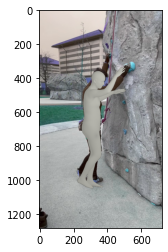

[216.39070129 347.65078735 207.53636169 675.14315796]


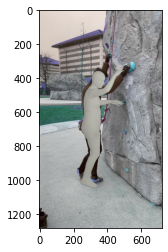

[219.67704773 348.62597656 210.15333557 671.83996582]


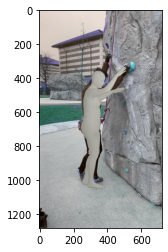

[221.67500305 350.26446533 207.1124115  660.78582764]


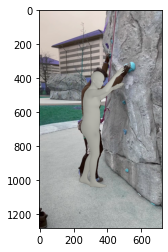

[217.58763123 346.53808594 221.60215759 673.59619141]


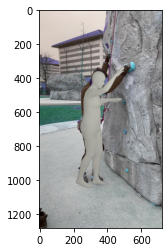

[222.98010254 333.45272827 240.36587524 683.29946899]


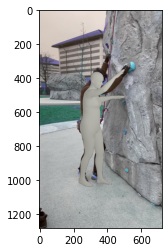

[226.27954102 324.67800903 256.34164429 684.98178101]


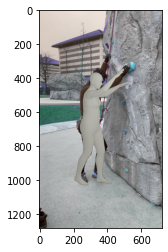

[219.45018005 243.45249939 354.55989075 764.37171936]


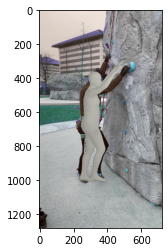

[219.23976135 231.83596802 368.29972839 802.0718689 ]


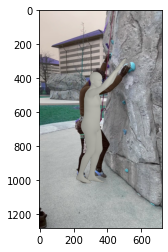

[215.28840637 230.6802063  375.55326843 797.73117065]


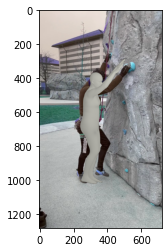

[216.15412903 235.98028564 374.27622986 787.90197754]


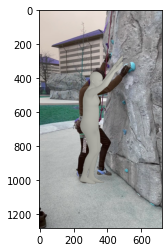

[216.6197052  243.34260559 373.94950867 776.03269958]


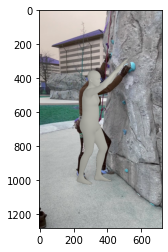

[217.43278503 238.26005554 366.30732727 777.99794006]


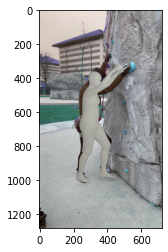

[211.93864441 266.97601318 373.53541565 736.61236572]


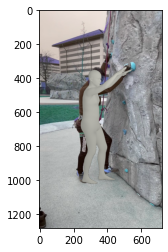

[206.74557495 251.54945374 374.78140259 755.26823425]


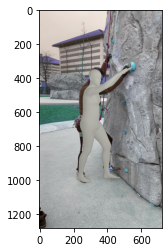

[206.32937622 253.67391968 376.54483032 751.37576294]


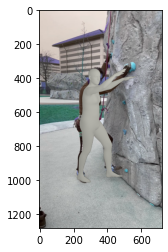

[210.72895813 253.21459961 371.5622406  742.62310791]


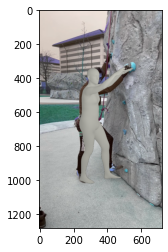

[202.26708984 244.52363586 375.44732666 769.47795105]


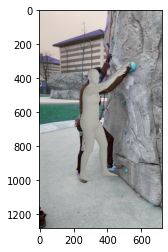

[203.86199951 240.80349731 372.17321777 776.59481812]


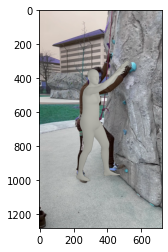

[206.49978638 240.0657959  371.41964722 777.00598145]


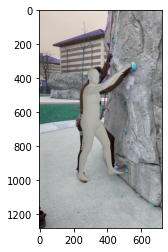

[206.45565796 239.81889343 369.61557007 778.67146301]


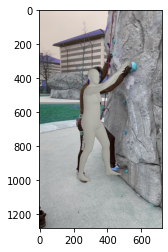

[209.21063232 247.8927002  367.89141846 767.18060303]


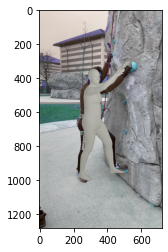

[211.58927917 251.5400238  363.45588684 765.63172913]


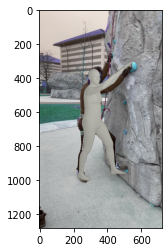

[213.74107361 244.7585144  362.18971252 774.04281616]


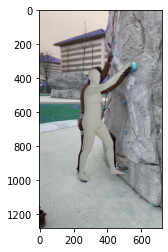

[214.10539246 242.43795776 362.2915802  777.72793579]


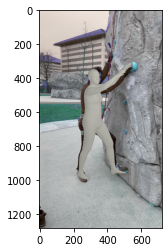

[218.3951416  280.24380493 347.46282959 717.31137085]


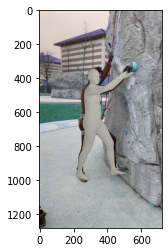

[218.83256531 270.96801758 352.5695343  726.7130127 ]


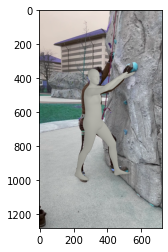

[222.93754578 248.34011841 359.56819153 765.33676147]


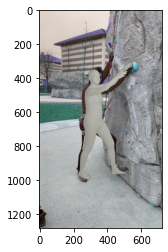

[224.96948242 264.96694946 343.90985107 730.75009155]


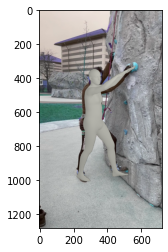

[237.41583252 262.0418396  347.58056641 747.65084839]


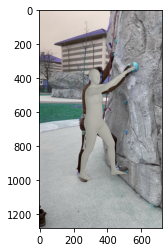

[224.99833679 273.94329834 342.96406555 714.39813232]


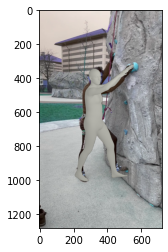

[226.23323059 302.83862305 335.24607849 702.77746582]


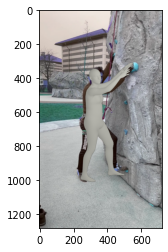

[243.29611206 241.07592773 345.01779175 762.01446533]


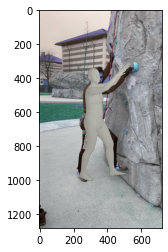

[242.24156189 242.76564026 350.60072327 755.80180359]


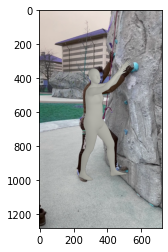

[226.15351868 278.60534668 342.45372009 704.60424805]


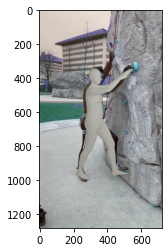

[230.57104492 223.57453918 350.86224365 784.42680359]


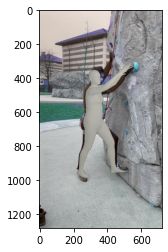

[238.29464722 268.40014648 373.75881958 747.72607422]


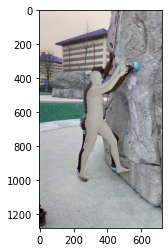

[239.6335144  267.02294922 377.43307495 750.6763916 ]


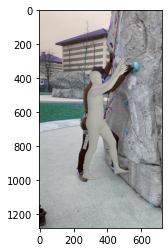

[237.88447571 236.64273071 349.02391052 759.4493103 ]


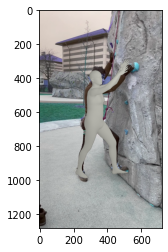

[241.75164795 219.51947021 348.93188477 781.95385742]


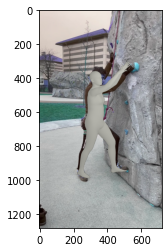

[248.85305786 222.61427307 343.10903931 772.96360779]


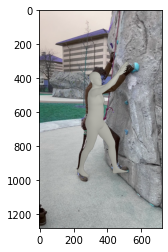

[242.13786316 253.12588501 377.76496887 777.84262085]


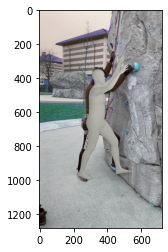

[237.43768311 219.2467804  381.31951904 819.18962097]


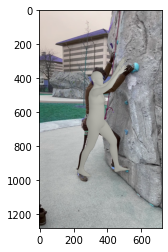

[235.18200684 217.62565613 365.01989746 791.44343567]


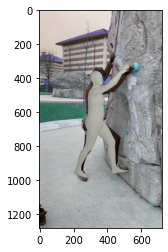

[241.55917358 207.23442078 356.91189575 801.37727356]


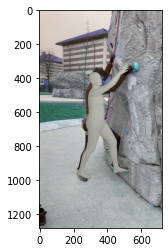

[238.40351868 221.53126526 373.66386414 825.28172302]


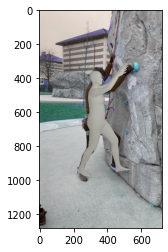

[237.24154663 281.18902588 348.65353394 715.68792725]


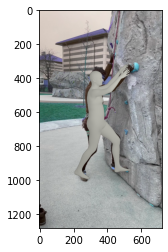

[244.39091492 212.64614868 343.57014465 799.59896851]


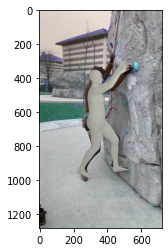

[246.67189026 193.01264954 336.9226532  829.79264832]


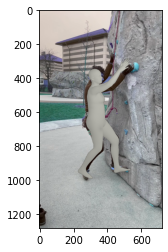

[250.37971497 186.79629517 337.55699158 815.44125366]


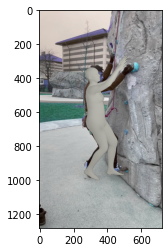

[251.26672363 187.08535767 339.34191895 808.17086792]


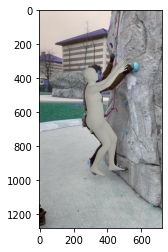

[254.31617737 182.12171936 330.65458679 795.39610291]


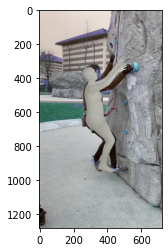

[246.73606873 260.78945923 358.34901428 683.52651978]


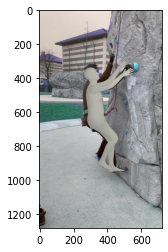

[242.76985168 157.2538147  347.41636658 814.76998901]


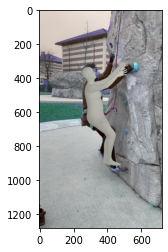

[242.12805176 166.60716248 345.43505859 814.3941803 ]


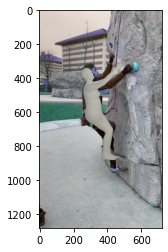

[249.82867432 149.59634399 347.28063965 824.49447632]


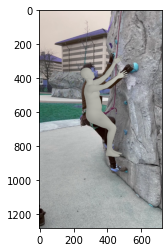

[246.42926025 158.24638367 349.64837646 820.423172  ]


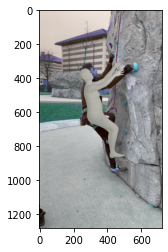

[246.14120483 163.60667419 353.57943726 816.08790588]


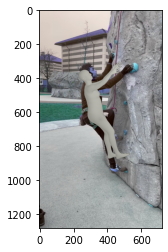

[252.88188171 192.08363342 345.36909485 780.52922058]


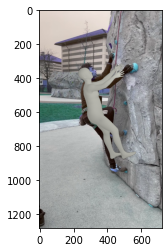

[245.04016113 236.38969421 351.19476318 725.60810852]


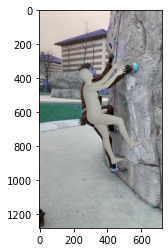

[241.57350159 234.97486877 348.71525574 729.82566833]


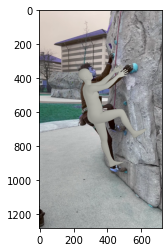

[242.00996399 235.54130554 347.9337616  724.83082581]


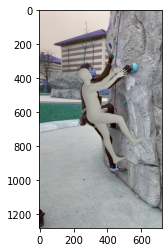

[246.58912659 187.05314636 345.26469421 802.81550598]


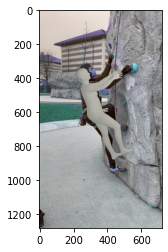

[237.01327515 159.78849792 347.80160522 837.1809845 ]


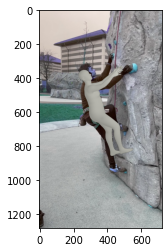

[238.43385315 156.33157349 344.22312927 835.93307495]


KeyboardInterrupt: 

In [75]:
for frame_id in range(100):
    frame_bbox = bboxes[frame_id]
    img = vid[frame_id]
    mesh_res = predict_mesh(hmr_model, img, frame_bbox)
    verts, orig_cam = mesh_res['verts'], mesh_res['orig_cam']
    mesh_img = render_mesh(img, verts[0], orig_cam[0])
    plt.imshow(mesh_img)
    plt.show()